In [175]:
"""
Loads result to dataframe and analyzes the results
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from format_urls.load_results_to_dataframe import load_results_to_dataframe


notebook_dir = os.getcwd()

In [176]:
top_10k = load_results_to_dataframe(
    file_name="data/top-10000-pages-and-screens-30-days-doi-20241004.csv",
    notebook_dir=notebook_dir,
)

top_10k["url"] = top_10k.apply(
    lambda row: "https://" + str(row["domain"]) + str(row["pagePath"]), axis=1
)

top_10k.head(10000)

,page_title,domain,pagePath,pageviews,url
0,Latest Earthquakes,earthquake.usgs.gov,/earthquakes/map/,27374679,https://earthquake.usgs.gov/earthquakes/map/
1,Webcam (U.S. National Park Service),www.nps.gov,/media/webcam/view.htm,695020,https://www.nps.gov/media/webcam/view.htm
2,NPS.gov Homepage (U.S. National Park Service),www.nps.gov,/index.htm,651717,https://www.nps.gov/index.htm
3,EarthExplorer,earthexplorer.usgs.gov,/,557336,https://earthexplorer.usgs.gov/
4,U.S. Department of the Interior | Bureau of Indian Education,www.bie.edu,/,507242,https://www.bie.edu/
...,...,...,...,...,...
9995,Bike Carriage Roads (U.S. National Park Service),www.nps.gov,/thingstodo/bike-carriage-roads.htm,808,https://www.nps.gov/thingstodo/bike-carriage-roads.htm
9996,Boulder Bridge Hike (U.S. National Park Service),www.nps.gov,/thingstodo/boulder-bridge-hike.htm,808,https://www.nps.gov/thingstodo/boulder-bridge-hike.htm
9997,"Buffalo River Below Lobelville, TN - USGS Water Data for the Nation",waterdata.usgs.gov,/monitoring-location/03604400/,808,https://waterdata.usgs.gov/monitoring-location/03604400/
9998,Camping - Organ Pipe Cactus National Monument (U.S. National Park Service),www.nps.gov,/orpi/planyourvisit/camping.htm,808,https://www.nps.gov/orpi/planyourvisit/camping.htm


In [177]:
single_domain = pd.DataFrame(top_10k[top_10k["domain"] == "www.nps.gov"])

In [182]:
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np


def extract_features(url):
    # Extract meaningful parts from the URL
    parts = url.split("/")
    return " ".join([part for part in parts if part and not part.startswith("www.")])


def preprocess_urls(urls):
    return [extract_features(url) for url in urls]


def find_optimal_k(data, max_k):
    silhouette_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
    return silhouette_scores.index(max(silhouette_scores)) + 2


def cluster_urls(urls, max_k=50):
    # Preprocess URLs
    processed_urls = preprocess_urls(urls)

    # Create TF-IDF vectors
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(processed_urls)

    # Find optimal number of clusters
    optimal_k = find_optimal_k(X, max_k)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans.fit(X)

    return kmeans.labels_


urls = single_domain["pagePath"].to_list()

# Perform clustering
cluster_labels = cluster_urls(urls)

# Add cluster labels to the DataFrame
single_domain_with_clusters = single_domain.copy()
single_domain_with_clusters["cluster"] = cluster_labels

# Display the new DataFrame
single_domain_with_clusters.head(10000)

,page_title,domain,pagePath,pageviews,url,cluster
1,Webcam (U.S. National Park Service),www.nps.gov,/media/webcam/view.htm,695020,https://www.nps.gov/media/webcam/view.htm,45
2,NPS.gov Homepage (U.S. National Park Service),www.nps.gov,/index.htm,651717,https://www.nps.gov/index.htm,42
9,Places to Get Interagency Passes (U.S. National Park Service),www.nps.gov,/planyourvisit/pickup-pass-locations.htm,364223,https://www.nps.gov/planyourvisit/pickup-pass-locations.htm,45
10,Yellowstone National Park (U.S. National Park Service),www.nps.gov,/yell/index.htm,294733,https://www.nps.gov/yell/index.htm,46
11,Current Conditions - Great Smoky Mountains National Park (U.S. National Park Service),www.nps.gov,/grsm/planyourvisit/conditions.htm,267880,https://www.nps.gov/grsm/planyourvisit/conditions.htm,36
...,...,...,...,...,...,...
9994,Beach Fires Within Point Reyes National Seashore - Point Reyes National Seashore (U.S. National Park Service),www.nps.gov,/pore/planyourvisit/beachfires.htm,808,https://www.nps.gov/pore/planyourvisit/beachfires.htm,45
9995,Bike Carriage Roads (U.S. National Park Service),www.nps.gov,/thingstodo/bike-carriage-roads.htm,808,https://www.nps.gov/thingstodo/bike-carriage-roads.htm,0
9996,Boulder Bridge Hike (U.S. National Park Service),www.nps.gov,/thingstodo/boulder-bridge-hike.htm,808,https://www.nps.gov/thingstodo/boulder-bridge-hike.htm,0
9998,Camping - Organ Pipe Cactus National Monument (U.S. National Park Service),www.nps.gov,/orpi/planyourvisit/camping.htm,808,https://www.nps.gov/orpi/planyourvisit/camping.htm,9


In [179]:
# Group by the 'cluster' column
grouped = single_domain_with_clusters.groupby("cluster")
pd.set_option("display.max_colwidth", None)


# Iterate over each group and print the first 'num_results' of the 'pagePath' column
for cluster_id, group in grouped:
    print(f"Cluster {cluster_id}:")
    print(group["url"].head(10))
    print("\n")

Cluster 0:
676                        https://www.nps.gov/thingstodo/hike-beehive-loop.htm
1236                   https://www.nps.gov/thingstodo/hike-bar-island-trail.htm
1381                     https://www.nps.gov/thingstodo/hike-precipice-loop.htm
1395                        https://www.nps.gov/thingstodo/campgrounds-badl.htm
1487    https://www.nps.gov/thingstodo/yell-grand-canyon-of-the-yellowstone.htm
1646                              https://www.nps.gov/thingstodo/ferncanyon.htm
1672                           https://www.nps.gov/thingstodo/tour-fdr-home.htm
1680                        https://www.nps.gov/thingstodo/romo_lakehaiyaha.htm
1711                 https://www.nps.gov/thingstodo/tour-vanderbilt-mansion.htm
1763                    https://www.nps.gov/thingstodo/hike-canyon-overlook.htm
Name: url, dtype: object


Cluster 1:
162     https://www.nps.gov/glac/planyourvisit/directions.htm
673     https://www.nps.gov/shen/planyourvisit/directions.htm
756     https://www.nps.gov

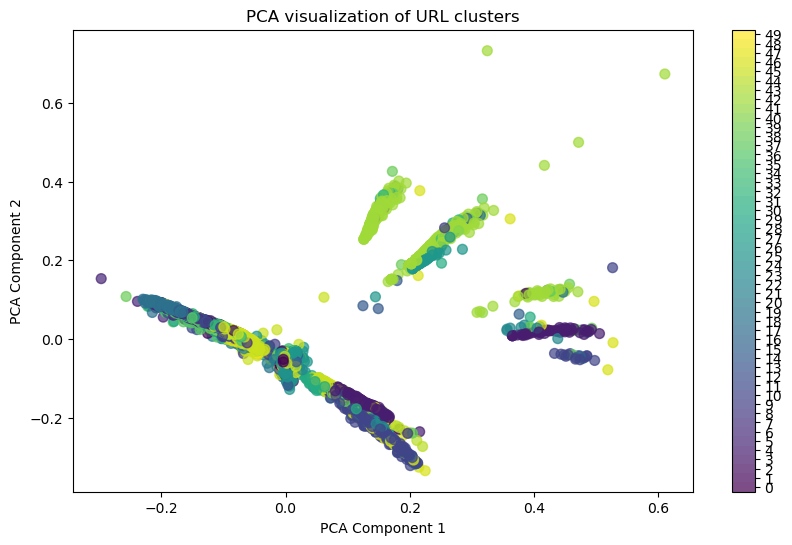

In [185]:
def visualize_clusters_pca(X, labels):
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X.toarray())  # Perform PCA transformation

    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap="viridis", s=50, alpha=0.7)
    plt.colorbar(boundaries=np.arange(max(labels) + 2) - 0.5).set_ticks(
        np.arange(max(labels) + 1)
    )
    plt.title("PCA visualization of URL clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()


urls = single_domain["pagePath"].to_list()
# Perform clustering
cluster_labels = cluster_urls(urls)

# Visualize clusters using PCA
visualize_clusters_pca(X, cluster_labels)